# San Francisco Crime Prediction
### Welcome to the San Francisco crime prediction notebook, where we will be predicting the type of crime commited in San Francisco given the dates, day of the week, PD district, address and location.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prepro
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Firstly, we will collect the train and test data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
X=train.copy()

In [4]:
X.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
# import urllib
# # gdf=train.copy()
# # gdf['Coordinates'] = list(zip(train.X, train.Y))
# # gdf
# # def create_gdf(df):
# #     gdf = df.copy()
# #     gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
# # #     gdf.Coordinates = gdf.Coordinates.apply(Point)
# #     gdf = gpd.GeoDataFrame(
# #         gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
# #     return gdf

# # train_gdf = create_gdf(train)

# # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # ax = world.plot(color='white', edgecolor='black')
# # train_gdf.plot(ax=ax, color='red')
# # plt.show()
# # Downloading the shapefile of the area 
# url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
# with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
#     shutil.copyfileobj(response, out_file)
# # Unzipping it
# with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('pd_data')
# # Loading to a geopandas dataframe
# for filename in os.listdir('./pd_data/'):
#     if re.match(".+\.shp", filename):
#         pd_districts = gpd.read_file('./pd_data/'+filename)
#         break
# # Defining the coordinate system to longitude/latitude
# pd_districts.crs={'init': 'epsg:4326'}

# # Merging our train dataset with the geo-dataframe
# pd_districts = pd_districts.merge(
#     train.groupby('PdDistrict').count().iloc[:, [0]].rename(
#         columns={'Dates': 'Incidents'}),
#     how='inner',
#     left_on='district',
#     right_index=True,
#     suffixes=('_x', '_y'))

# # Transforming the coordinate system to Spherical Mercator for
# # compatibility with the tiling background
# pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# # Calculating the incidents per day for every district
# train_days = train.groupby('Date').count().shape[0]
# pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# # Ploting the data
# fig, ax = plt.subplots(figsize=(10, 10))
# pd_districts.plot(
#     column='inc_per_day',
#     cmap='Reds',
#     alpha=0.6,
#     edgecolor='r',
#     linestyle='-',
#     linewidth=1,
#     legend=True,
#     ax=ax)

# def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
#     """Function that add the tile background to the map"""
#     xmin, xmax, ymin, ymax = ax.axis()
#     basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
#     ax.imshow(basemap, extent=extent, interpolation='bilinear')
#     # restore original x/y limits
#     ax.axis((xmin, xmax, ymin, ymax))

# # Adding the background
# add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# # Adding the name of the districts
# for index in pd_districts.index:
#     plt.annotate(
#         pd_districts.loc[index].district,
#         (pd_districts.loc[index].geometry.centroid.x,
#          pd_districts.loc[index].geometry.centroid.y),
#         color='#353535',
#         fontsize='large',
#         fontweight='heavy',
#         horizontalalignment='center'
#     )

# ax.set_axis_off()
# plt.show()

In [6]:
X.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [8]:
X.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [9]:
len(X.Category.unique())

39

In [10]:
len(X.Descript.unique())

879

# Feature engineering

### The feature engineering begins by encoding the categorical features (Day of the week, PD district, address and category) using a LabelEncoder.

In [11]:
for i in ['DayOfWeek', 'PdDistrict', 'Address', 'Category']:
    X[i] = prepro.LabelEncoder().fit_transform(X[i])
    if i not in ['Category']:
        test[i] = prepro.LabelEncoder().fit_transform(test[i])

In [12]:
X.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,37,WARRANT ARREST,6,4,"ARREST, BOOKED",19790,-122.425892,37.774599
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,6,4,"ARREST, BOOKED",19790,-122.425892,37.774599
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,6,4,"ARREST, BOOKED",22697,-122.424363,37.800414
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,6,4,NONE,4266,-122.426995,37.800873
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,6,5,NONE,1843,-122.438738,37.771541


### Now the year, month, day, hour and minute variables are extracted out of the 'date' feature and added to the dataset.

In [13]:
X['year'] = pd.to_datetime(X['Dates']).dt.year
X['month'] = pd.to_datetime(X['Dates']).dt.month
X['day'] = pd.to_datetime(X['Dates']).dt.day
X['hour'] = pd.to_datetime(X['Dates']).dt.hour
X['minute'] = pd.to_datetime(X['Dates']).dt.minute

test['year'] = pd.to_datetime(test['Dates']).dt.year
test['month'] = pd.to_datetime(test['Dates']).dt.month
test['day'] = pd.to_datetime(test['Dates']).dt.day
test['hour'] = pd.to_datetime(test['Dates']).dt.hour
test['minute'] = pd.to_datetime(test['Dates']).dt.minute

### The final piece of feature engineering which is done is binning the month, hour and day features.

In [14]:
for i in [[6, 'month'], [8, 'hour'], [10, 'day']]:
    feature = i[1]
    bins = i[0]
    X[feature+' bin'] = np.floor_divide(X[feature], len(np.unique(X[feature]))/bins)

In [15]:
y = X['Category']
X = X.drop(['Descript', 'Resolution', 'Dates', 'Category'], axis=1)
test = test.drop(['Dates', 'Id'], axis=1)

# Data visualisation

### We start visualising the data with a correlation heatmap for all the features in our X dataset.

In [16]:
X.head()

,DayOfWeek,PdDistrict,Address,X,Y,year,month,day,hour,minute,month bin,hour bin,day bin
0,6,4,19790,-122.425892,37.774599,2015,5,13,23,53,2.0,7.0,4.0
1,6,4,19790,-122.425892,37.774599,2015,5,13,23,53,2.0,7.0,4.0
2,6,4,22697,-122.424363,37.800414,2015,5,13,23,33,2.0,7.0,4.0
3,6,4,4266,-122.426995,37.800873,2015,5,13,23,30,2.0,7.0,4.0
4,6,5,1843,-122.438738,37.771541,2015,5,13,23,30,2.0,7.0,4.0


In [17]:
test.head()

,DayOfWeek,PdDistrict,Address,X,Y,year,month,day,hour,minute
0,3,0,6407,-122.399588,37.735051,2015,5,10,23,59
1,3,0,9744,-122.391523,37.732432,2015,5,10,23,51
2,3,4,6336,-122.426002,37.792212,2015,5,10,23,50
3,3,2,10633,-122.437394,37.721412,2015,5,10,23,45
4,3,2,10633,-122.437394,37.721412,2015,5,10,23,45


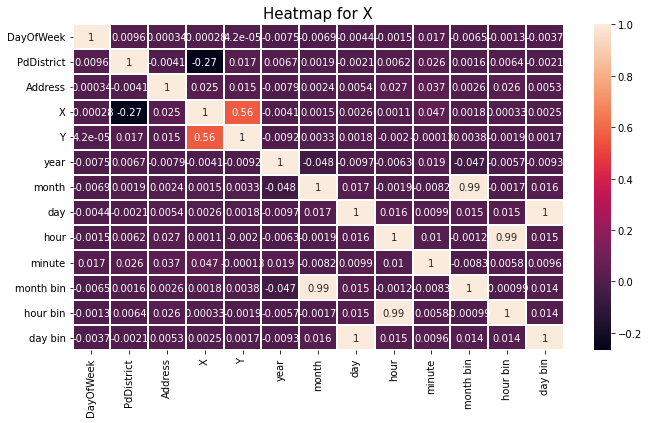

In [18]:
fig = plt.figure(figsize=(11, 6))
sns.heatmap(X.corr(), annot=True, linewidths=.1)
plt.title('Heatmap for X', fontsize=15)
# plt.show()
plt.savefig('heatmap_corr.svg')

### Then, the amount of crime per years, day of the week, months, hours and minute are plotted using a bar chart.

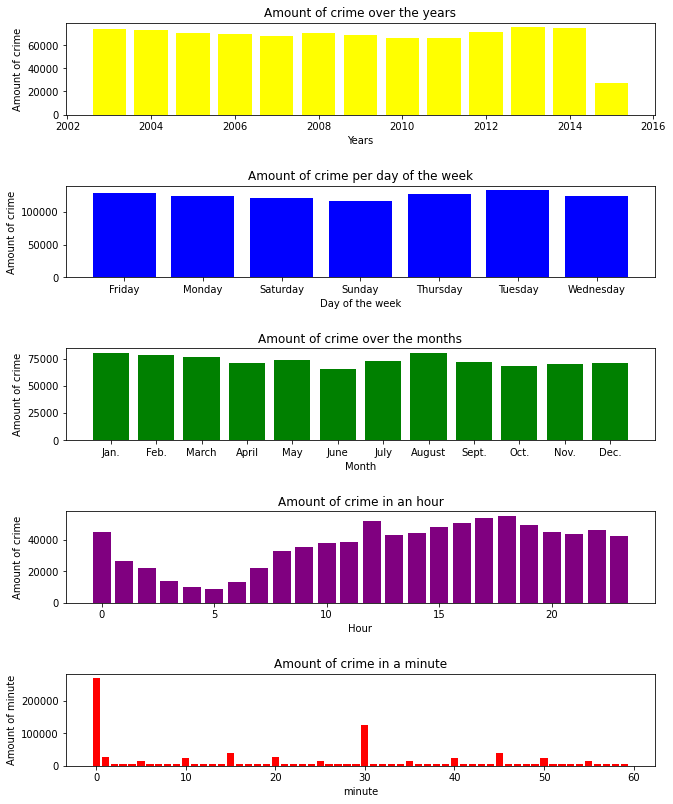

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 12))
fig.tight_layout(pad=5.0)

count = Counter(X['year'])
ax1.bar(count.keys(), count.values(), color='yellow')
ax1.set_title('Amount of crime over the years')
ax1.set_ylabel('Amount of crime')
ax1.set_xlabel('Years')

count = Counter(X['DayOfWeek'])
ax2.bar(np.unique(train['DayOfWeek']), count.values(), color='blue')
ax2.set_title('Amount of crime per day of the week')
ax2.set_ylabel('Amount of crime')
ax2.set_xlabel('Day of the week')

count = Counter(X['month'])
ax3.bar(['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'August','Sept.','Oct.','Nov.','Dec.'],count.values(),color='green')
ax3.set_title('Amount of crime over the months')
ax3.set_ylabel('Amount of crime')
ax3.set_xlabel('Month')

count = Counter(X['hour'])
ax4.bar(count.keys(), count.values(), color='purple')
ax4.set_title('Amount of crime in an hour')
ax4.set_ylabel('Amount of crime')
ax4.set_xlabel('Hour')

count = Counter(X['minute'])
ax5.bar(count.keys(), count.values(), color='red')
ax5.set_title('Amount of crime in a minute')
ax5.set_ylabel('Amount of minute')
ax5.set_xlabel('minute')

# plt.show()
plt.savefig("dataplot.svg")

### The following graphs take a look at the types of crime commited and the neighbourhoods in which they occurred.

C:\Users\Unknown\AppData\Local\Temp\ipykernel_2604\872746815.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data[0], rotation=90)


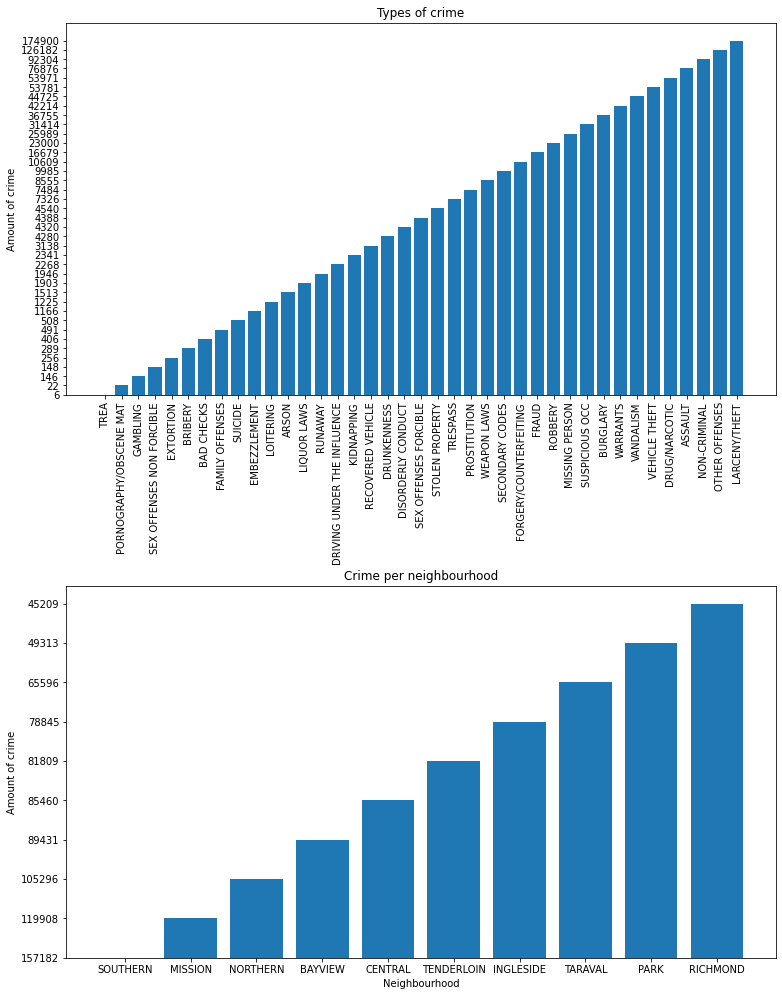

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 18))
fig.tight_layout(pad=17.0)

count = Counter(train['PdDistrict'])
data = (np.array(sorted(count.items(), key=lambda x:x[1], reverse=True)).T).tolist()
plt.bar(data[0], data[1])
plt.title('Crime per neighbourhood')
plt.ylabel('Amount of crime')
plt.xlabel('Neighbourhood')

count = Counter(train['Category'])
data = (np.array(sorted(count.items(), key=lambda x:x[1])).T).tolist()
ax1.tick_params()
ax1.bar(data[0], data[1])
ax1.set_xticklabels(data[0], rotation=90)
ax1.set_title('Types of crime')
ax1.set_ylabel('Amount of crime')
# plt.show()
plt.savefig("data1.svg")

### Finally, we create three bar charts which show the amount of crime in all of the bins which we created earlier.

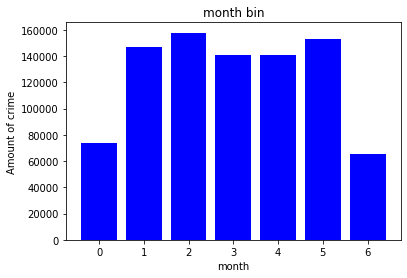

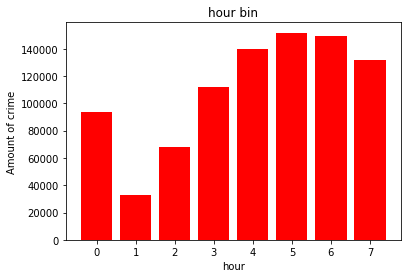

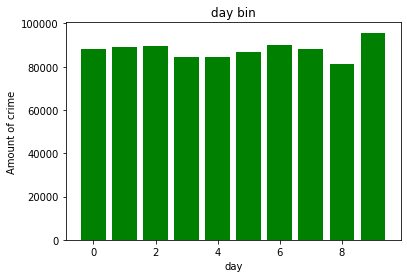

In [33]:
for i in [['month bin', 'blue'], ['hour bin', 'red'], ['day bin', 'green']]:
    count = Counter(X[i[0]])
    color = i[1]
    plt.bar(count.keys(), count.values(), color=color)
    plt.title(i[0])
    plt.ylabel('Amount of crime')
    plt.xlabel(i[0].split()[0])
    plt.show()
#     plt.savefig(f"{i[1]}.svg")

# Predicting crime with a neural network

### In order to feed the data to our model, we must first make y categorical and standardise X train and test.

In [ ]:
X.columns

In [22]:
# X.drop([ 'month bin', 'hour bin', 'day bin'],axis=1,inplace=True)

In [23]:
X.head()

,DayOfWeek,PdDistrict,Address,X,Y,year,month,day,hour,minute,month bin,hour bin,day bin
0,6,4,19790,-122.425892,37.774599,2015,5,13,23,53,2.0,7.0,4.0
1,6,4,19790,-122.425892,37.774599,2015,5,13,23,53,2.0,7.0,4.0
2,6,4,22697,-122.424363,37.800414,2015,5,13,23,33,2.0,7.0,4.0
3,6,4,4266,-122.426995,37.800873,2015,5,13,23,30,2.0,7.0,4.0
4,6,5,1843,-122.438738,37.771541,2015,5,13,23,30,2.0,7.0,4.0


In [24]:
y

0         37
1         21
2         21
3         16
4         16
          ..
878044    25
878045    16
878046    16
878047    35
878048    12
Name: Category, Length: 878049, dtype: int32

In [25]:
np.array(y)

array([37, 21, 21, ..., 16, 35, 12])

In [26]:
# from sklearn.linear_model import LogisticRegression
# reg=LogisticRegression()
# reg.fit(X_train,y_train)

In [27]:
y = to_categorical(y)
X_train, X_val, y_train, y_val = train_test_split(X[['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'year', 'month', 'day',
       'hour', 'minute']], y, random_state=1, test_size=0.2)
X_train = prepro.StandardScaler().fit_transform(X_train)
X_val = prepro.StandardScaler().fit_transform(X_val)

In [28]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
X_train.shape

(702439, 10)

In [30]:
X_train[0].shape

(10,)

In [31]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.], dtype=float32)

### The last part of this notebook is to create and tune a neural network.

Epoch 1/100
2195/2195 [==============================] - 14s 6ms/step - loss: 2.6221 - accuracy: 0.2157 - val_loss: 2.5616 - val_accuracy: 0.2321
Epoch 2/100
2195/2195 [==============================] - 12s 6ms/step - loss: 2.5554 - accuracy: 0.2320 - val_loss: 2.5180 - val_accuracy: 0.2414
Epoch 3/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.5196 - accuracy: 0.2429 - val_loss: 2.4945 - val_accuracy: 0.2484
Epoch 4/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.5032 - accuracy: 0.2468 - val_loss: 2.4808 - val_accuracy: 0.2518
Epoch 5/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4934 - accuracy: 0.2514 - val_loss: 2.4708 - val_accuracy: 0.2557
Epoch 6/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4895 - accuracy: 0.2510 - val_loss: 2.4676 - val_accuracy: 0.2545
Epoch 7/100
2195/2195 [==============================] - 12s 5ms/step - loss: 2.4763 - accuracy: 0.2537 - val_loss: 2.4611 -

Epoch 57/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4075 - accuracy: 0.2732 - val_loss: 2.3882 - val_accuracy: 0.2763
Epoch 58/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4059 - accuracy: 0.2717 - val_loss: 2.3913 - val_accuracy: 0.2738
Epoch 59/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4050 - accuracy: 0.2717 - val_loss: 2.3905 - val_accuracy: 0.2756
Epoch 60/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4069 - accuracy: 0.2729 - val_loss: 2.3893 - val_accuracy: 0.2747
Epoch 61/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4057 - accuracy: 0.2718 - val_loss: 2.3892 - val_accuracy: 0.2761
Epoch 62/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4083 - accuracy: 0.2732 - val_loss: 2.3874 - val_accuracy: 0.2770
Epoch 63/100
2195/2195 [==============================] - 13s 6ms/step - loss: 2.4054 - accuracy: 0.2732 - val_loss: 2

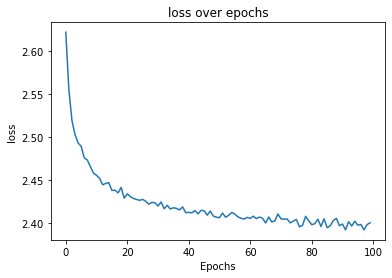

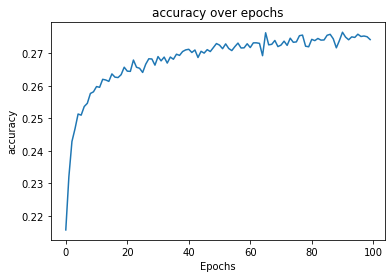

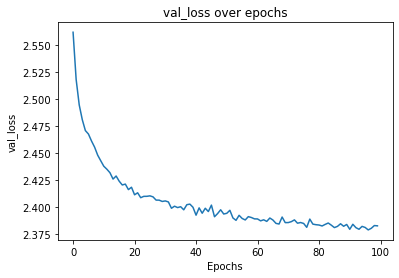

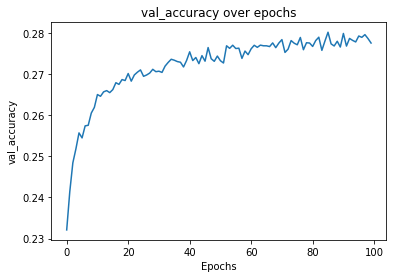

In [282]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(39, activation='softmax'))
# model.summary()    
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')   
# model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, steps_per_epoch=2195)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, steps_per_epoch=2195)        
for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

In [283]:
pre=model.predict(test)
pre[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

### Thank you for reading my notebook.

### If you enjoyed this notebook and found it helpful, please upvote it so that I can do more of these.

In [55]:
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# # X, y = make_classification(random_state=42)

# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe.fit(X_train, y_train)  # apply scaling on training data
# # Pipeline(steps=[('standardscaler', StandardScaler()),
# #                 ('logisticregression', LogisticRegression())])

# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'year', 'month', 'day',
       'hour', 'minute']],y, random_state=42)
reg=LogisticRegression(multi_class='multinomial',max_iter=10000)
# reg=LogisticRegression(multi_class='multinomial',max_iter=10000,verbose=1)
reg.fit(X_train,y_train)

C:\Users\Unknown\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [56]:
y_pred=reg.predict(X_test)

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

C:\Users\Unknown\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Unknown\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       382
           1       0.15      0.04      0.06     19231
           2       0.00      0.00      0.00        89
           3       0.00      0.00      0.00        72
           4       0.00      0.00      0.00      9247
           5       0.00      0.00      0.00      1018
           6       0.00      0.00      0.00       585
           7       0.21      0.06      0.09     13457
           8       0.00      0.00      0.00      1076
           9       0.00      0.00      0.00       274
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00       106
          12       0.00      0.00      0.00      2604
          13       0.00      0.00      0.00      4036
          14       0.00      0.00      0.00        43
          15       0.00      0.00      0.00       549
          16       0.22      0.78      0.35     43883
          17       0.00    

C:\Users\Unknown\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
import joblib
joblib.dump(reg,'deep_final.pkl')

['deep_final.pkl']

In [60]:
reg.evaluate(X_test,y_test)

AttributeError: 'LogisticRegression' object has no attribute 'evaluate'

In [336]:
import joblib
regg=joblib.load('deep')

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://7abf9c7f-630b-488c-9b4b-284474c1b001/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
# filename = 'finalized_model.sav'
# joblib.dump(model, filename)
 
# # some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)

In [250]:
import pickle
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

UnpicklingError: invalid load key, '/'.

In [348]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


In [350]:
from keras.models import model_from_json
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


In [ ]:
model.predict(test)[0]